In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 13.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 99.1 MB/s eta 0:00:00:00:010:01


In [39]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [5]:
IMG_size=(80,80)
channels=1
char_path=r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

In [6]:
# finding the top 10 characters with most images
char_dict={}
for char in os.listdir(char_path):
    char_dict[char]=len(os.listdir(os.path.join(char_path,char)))
char_dict=caer.sort_dict(char_dict,descending=True)
char_dict=char_dict[:10]

In [7]:
characters=[]
for i in char_dict:
    characters.append(i[0])
len(characters)    

10

In [8]:
# create a traning data
train=caer.preprocess_from_dir(char_path,characters,channels=channels,IMG_SIZE=IMG_size,isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 3.4566245079040527s
[INFO] At 1000 files
[INFO] 1454 files found in 3.06423282623291s
[INFO] At 1000 files
[INFO] 1452 files found in 3.3469817638397217s
[INFO] At 1000 files
[INFO] 1354 files found in 3.275381326675415s
[INFO] At 1000 files
[INFO] 1342 files found in 3.0706734657287598s
[INFO] At 1000 files
[INFO] 1291 files found in 3.130098819732666s
[INFO] At 1000 files
[INFO] 1206 files found in 3.3084704875946045s
[INFO] At 1000 files
[INFO] 1194 files found in 3.2779974937438965s
[INFO] At 1000 files
[INFO] 1193 files found in 2.9683380126953125s
[INFO] At 1000 files
[INFO] 1079 files found in 3.125230073928833s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 2m 38s


In [9]:
len(train)

13811

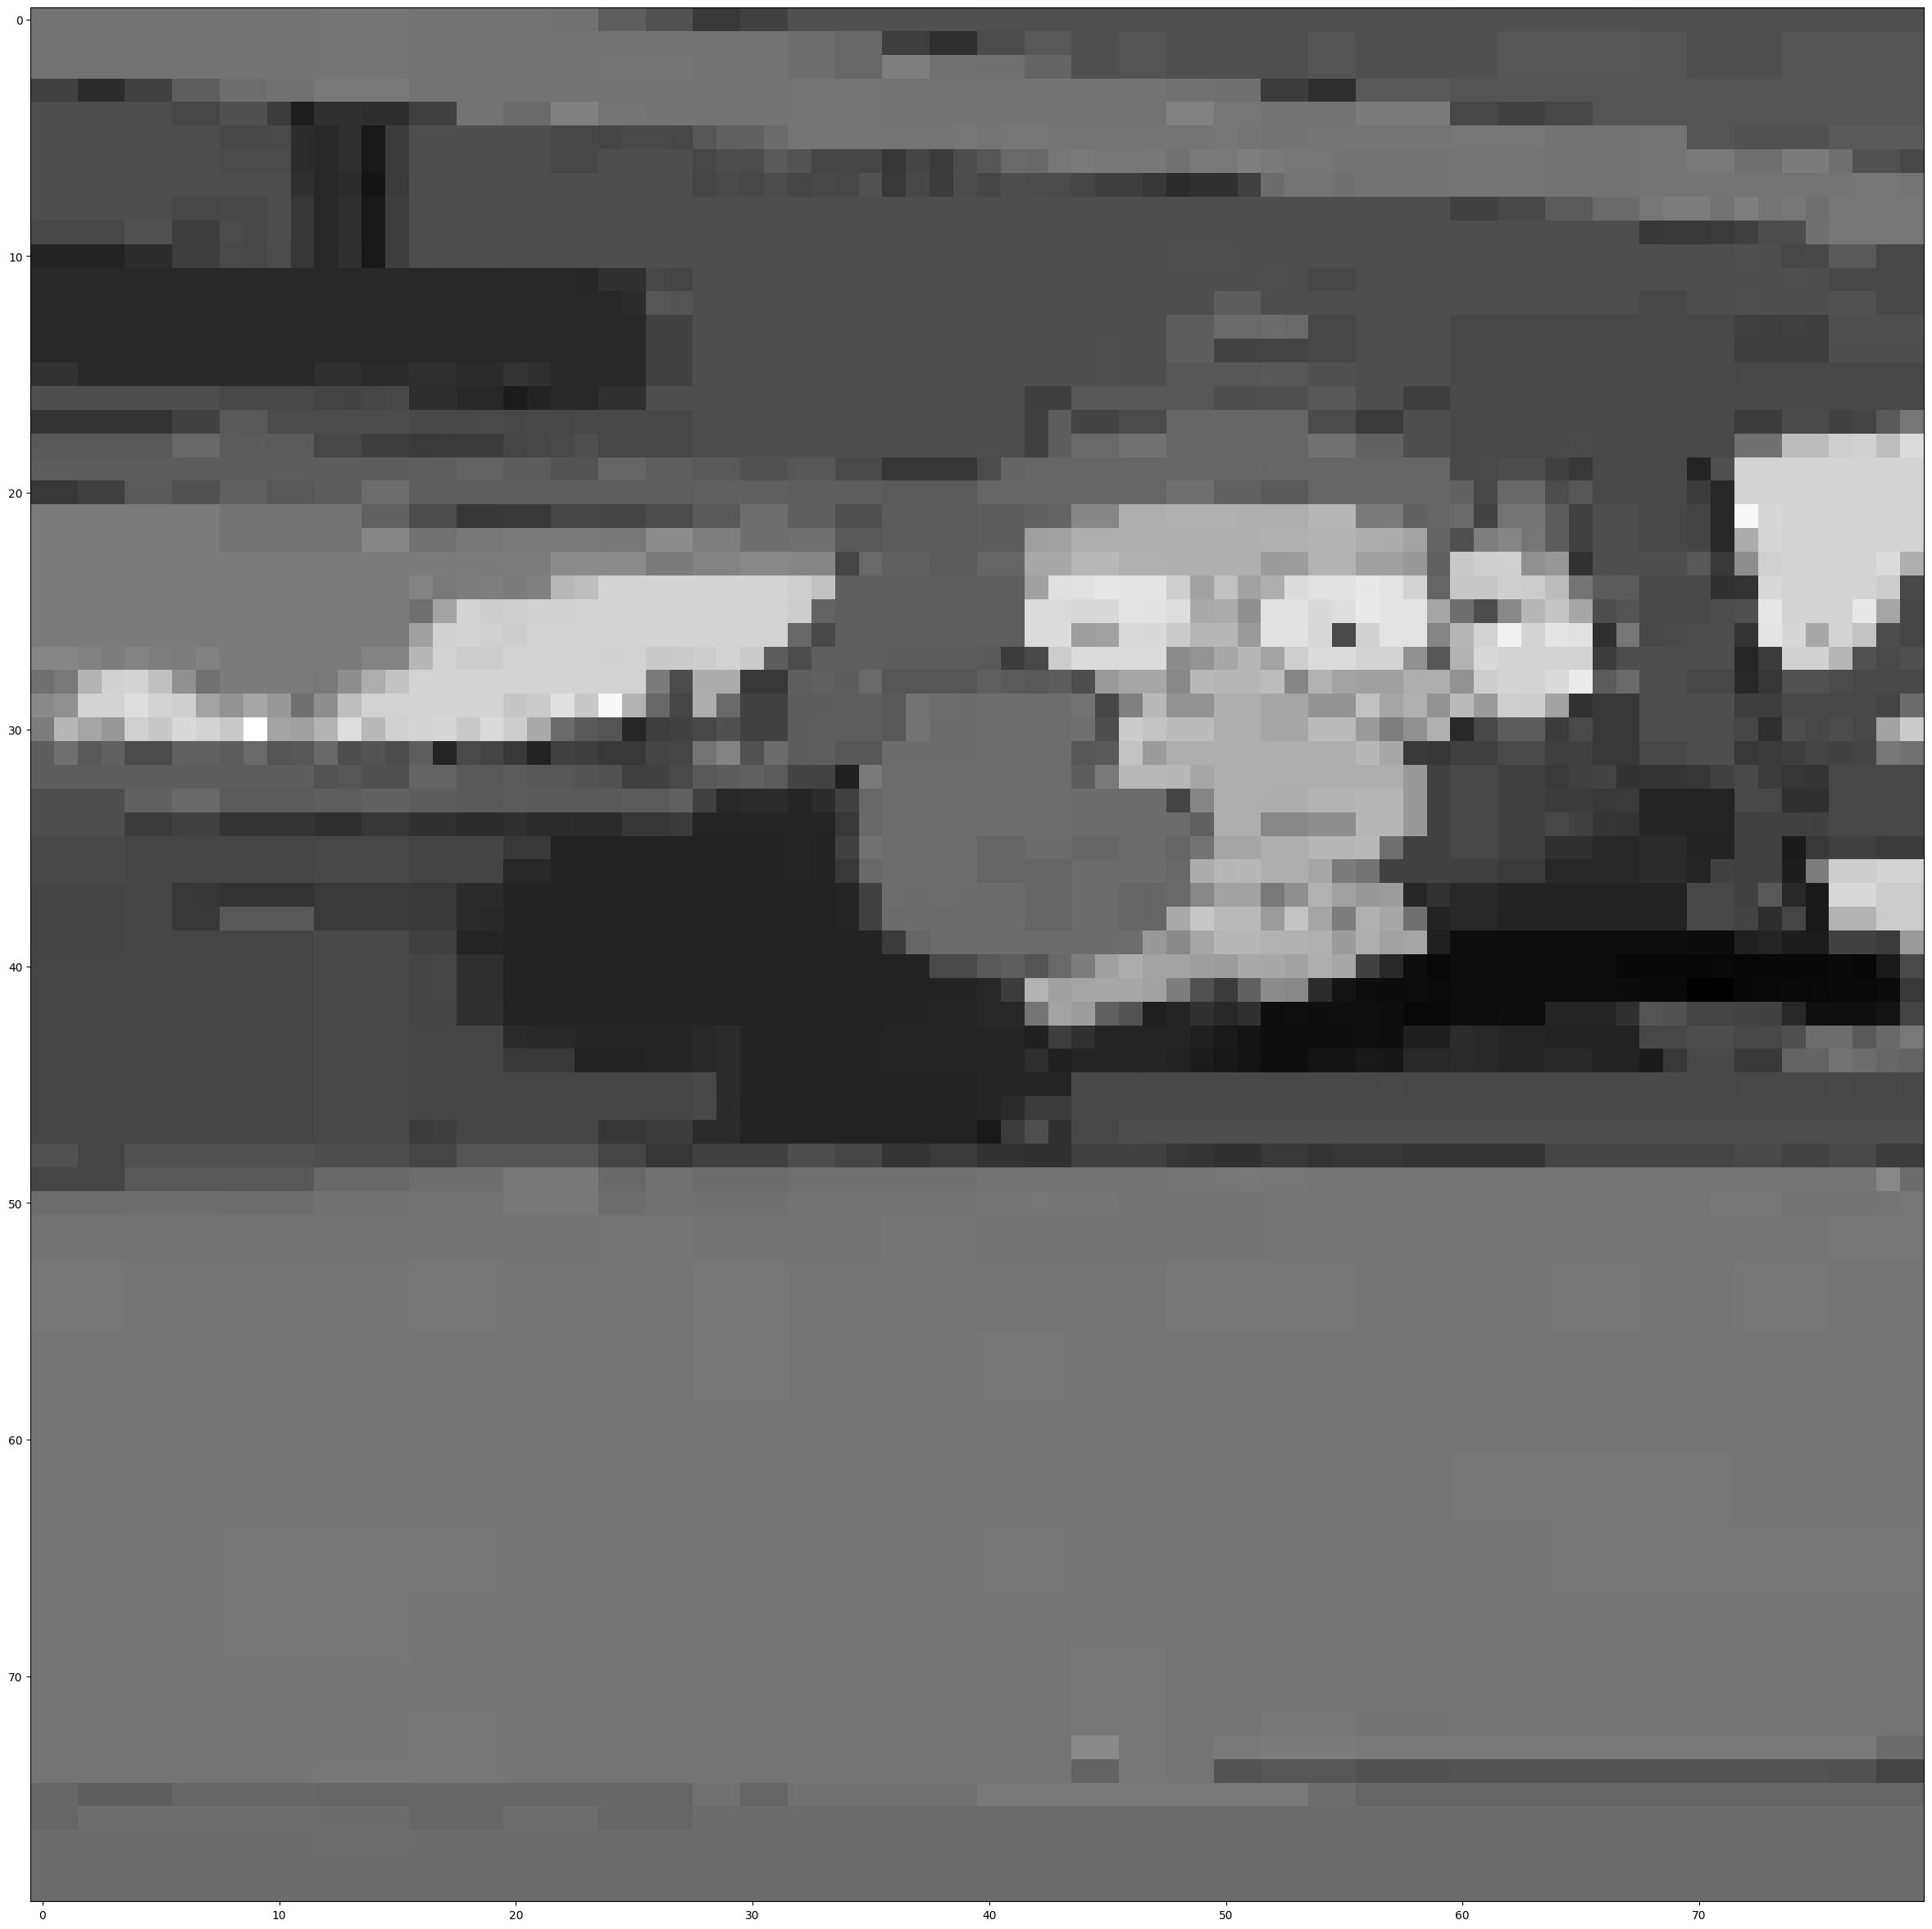

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0],cmap='gray')
plt.show()

In [12]:
featureSet,labels=caer.sep_train(train,IMG_SIZE=IMG_size)

In [13]:
from tensorflow.keras.utils import to_categorical
# normalize the feature set  (==>[0,1])
featureSet=caer.normalize(featureSet)
labels=to_categorical(labels,len(characters))

In [14]:
x_train,x_val,y_train,y_val=caer.train_val_split(featureSet,labels,val_ratio=0.2)

In [21]:
BATCH_SIZE=32
epochs=10

In [45]:
#Image Data Genrator
datagen=canaro.generators.imageDataGenerator()
traingen=datagen.flow(x_train,y_train,batch_size=BATCH_SIZE)

In [50]:
model = create_simpsons_model(
    IMG_SIZE=IMG_size,
    channels=channels,
    output_dim=len(characters),
    loss='binary_crossentropy',
    decay=1e-6,
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True
)


In [49]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD

def create_simpsons_model(IMG_SIZE, channels, output_dim, loss='binary_crossentropy',
                          decay=1e-6, learning_rate=0.001, momentum=0.9, nesterov=True):
    model = Sequential()

    # First block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], channels)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Second block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    # Optimizer
    optimizer = SGD(learning_rate=learning_rate, decay=decay, momentum=momentum, nesterov=nesterov)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


In [52]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 80, 80, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 78, 78, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 39, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 39, 39, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 39, 39, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1024)                │      84,935,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,721,290 (327.00 MB)

 Trainable params: 85,721,290 (327.00 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]

In [ ]:
traning=model.fit(train_gen,
                 steps_per_epoch=len(x_train)//BATCH_SIZE,
                 EPOCHS=epochs,
                 validation_data=(x_val,y_val),
                 validation_steps=len(y_val)//B)